# Can Language Models Solve Olympiad Programming?

In this tutorial, you will build a computing olympiad agent that leverages three complementary techniques to boost performance: **reflection**, **retrieval**, and **human-in-the-loop** collaboration. You will construct an agentic graph capable of answering programming questions of increasing difficulty.

1. **Reflection**: In part 1, you will create a zero-shot tool calling agent and prompt it to reflect on the test case results to correct its initial errors. 
2. **Retrieval**: In Part 2, you will implement an initial retrieval step as "episodic memory" for the agent that retrieves high-quality few-shot examples from our corpora of programming problems to help solve the **bronze** level question.
3. **Human-in-the-loop**: In part 3, you will use `interrupt_before` on an additional "human" node to guide the agent to a better answer.

While LLMs are not yet capable of autonomously solving all these problems, through better agent design, you can create a system that far surpasses the capabilities of a basic ReAct agent at answering these questions. 

Your final agent graph will be structured like the diagram below:

![diagram](./img/diagram.png)

The techniques in this tutorial are all adapted from the paper "Can Language Models Solve Olympiad Programming?" by Quan Shi, Michael Tang, Karthik Narasimhan, and Shunyu Yao. You can check out their paper at the following link:

[![arXiv](http://img.shields.io/badge/cs.CL-arXiv%3A2404.10952v1-B31B1B.svg)](https://arxiv.org/abs/2404.10952v1)



Before diving in, let's set up our machine. This will involve installing dependencies, fetching the dataset, and defining a utility function.

## Setup

For this tutorial, we will need to install some dependencies, fetch the Olympiad dataset, and define a utility function to help run the candidate solutions to see if they pass the test cases.

First, install the requirements.

In [ ]:
%pip install -U langgraph langsmith langchain_anthropic datasets

In [1]:
import getpass
import os


def _get_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_get_env("ANTHROPIC_API_KEY")
# Recommended
_get_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"

#### Data

Fetch the USACO benchmark data using the util below:

In [2]:
import os
import zipfile

import datasets
import requests

usaco_url = "https://storage.googleapis.com/benchmarks-artifacts/usaco/usaco_sampled_with_tests.zip"
zip_path = "usaco.zip"
extract_path = "usaco_datasets"

response = requests.get(usaco_url)
with open(zip_path, "wb") as file:
    file.write(response.content)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

os.remove(zip_path)

ds = datasets.load_from_disk(os.path.join(extract_path, "usaco_v3_sampled_with_tests"))

#### Test Evaluation Utils

We also need a way to evaluate our generated code. We will use this unsafe code execution program to run the generated code against our test cases.
**Note:** The code below runs arbitrary code on your local machine! Proceed with caution.

In [3]:
import multiprocessing
import queue
import subprocess
import sys
import time
import traceback

multiprocessing.set_start_method("fork", force=True)
# WARNING
# This program exists to execute untrusted model-generated code. Although
# it is highly unlikely that model-generated code will do something overtly
# malicious in response to this test suite, model-generated code may act
# destructively due to a lack of model capability or alignment.
# Users are strongly encouraged to sandbox this evaluation suite so that it
# does not perform destructive actions on their host or network.
# Proceed at your own risk:


def exec_program(q, program, input_data, expected_output, timeout):
    try:
        start_time = time.time()
        process = subprocess.Popen(
            [sys.executable, "-c", program],
            stdin=subprocess.PIPE,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,
        )
        stdout, stderr = process.communicate(input=input_data, timeout=timeout)
        if time.time() - start_time > timeout:
            raise TimeoutError("Execution timed out.")
        if process.returncode != 0:
            q.put(f"failed: {stderr}")
        else:
            if stdout.strip() == expected_output.strip():
                q.put("passed")
            else:
                q.put(f"wrong answer. Expected '{expected_output}', got '{stdout}'")
    except subprocess.TimeoutExpired:
        process.kill()
        q.put("timed out")
    except Exception as e:
        q.put(f"failed: {traceback.format_exc()}")


def check_correctness(
    program: str, input_data: str, expected_output: str, timeout: float
) -> str:
    q = multiprocessing.Queue()
    process = multiprocessing.Process(
        target=exec_program, args=(q, program, input_data, expected_output, timeout)
    )
    process.start()
    process.join(timeout=timeout + 1)
    if process.is_alive():
        process.terminate()
        process.join()
        result = "timed out"
    else:
        try:
            result = q.get_nowait()
        except queue.Empty:
            result = "no result returned"
    return result

Let's check an example program and output to see how it works:

In [6]:
program_code = "print('hello, world!')"
input_data = ""
expected_output = "hello, world!"
timeout = 2

test_result = check_correctness(program_code, input_data, expected_output, timeout)
print("Example 1: ", test_result)
test_result = check_correctness("print('goodbye')", input_data, "hi there", timeout)
print("Example 2: ", test_result)

Example 1:  passed
Example 2:  wrong answer. Expected 'hi there', got 'goodbye
'


## Part 1: Zero-Shot with Reflection

In our first section, we will build a simple zero-shot tool-calling agent to try to solve these problems. We will incorporate a simple form of [reflection](https://www.youtube.com/watch?v=v5ymBTXNqtk) directly in the agent's tool calling schema by adding a "reasoning" field. Furthermore, Claude was trained to "reason" with freeform text prior to invoking any tools. Together, this should induce reflective "chain-of-thought" prompting.

_Note: this diverges somewhat from the paper's implementation, which uses an explicit reflection step with a variation of the [Reflexion](../reflexion/reflexion.ipynb) prompt._

By the end of this section, we will have built a reflective zero-shot programming agent that looks like the section marked "Part 1" in the system diagram below:

![Part 1 diagram](./img/diagram-part-1.png)


### State

LangGraph's main primitive is the `StateGraph`, which you use to define an agent as a controllable state machine.  The graph has `node`'s (python functions) that perform the work, and `edge`s that define how to route between the nodes.
The `State` defines the interface between each node and carries all the information your agent needs.

Below, define a `State` for our programming olympiad agent. The `messages` will track the sequence of submissions (and test case feedback) as chat history. The `status` field will flip from `in_progress` to `success` if the submission passes all test cases.
The other fields (test_cases, runtime_limit) are used by the `evaluation` node to test the agent's submissions. These values are not seen by the agent itself.

In [5]:
from typing import Annotated, Optional

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class TestCase(TypedDict):
    inputs: str
    outputs: str


class State(TypedDict):
    # Append-only chat memory so the agent can try to recover from initial mistakes.
    messages: Annotated[list[AnyMessage], add_messages]
    # From the dataset. These are used for testing.
    test_cases: list[TestCase]
    runtime_limit: int
    status: str

Now, convert the dataset into inputs our graph will accept.

In [17]:
input_states = [
    {
        "messages": [("user", row["description"])],
        "test_cases": row["test_cases"],
        "runtime_limit": row["runtime_limit"],
        "status": "in_progress",
        "problem_level": row["problem_level"],
    }
    for row in ds
]

#### Node 1: Solver

Create a `solver` node that prompts an LLM "agent" to use a [writePython tool](https://python.langchain.com/docs/integrations/chat/anthropic/#beta-tool-calling) to generate the submitted code.

In [8]:
from langchain_core.language_models import BaseChatModel
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field


class writePython(BaseModel):
    """Write python code that resolves the problem."""

    reasoning: str = Field(..., description="Conceptual solution.")
    pseudocode: str = Field(..., description="Detailed English pseudocode.")
    code: str = Field(..., description="Valid Python 3 solution to the problem")


class Solver:
    def __init__(self, llm: BaseChatModel, prompt: ChatPromptTemplate):
        self.runnable = prompt | llm.bind_tools([writePython])

    def __call__(self, state: State) -> dict:
        # Our agent only can see the "messages" and will ignore the test info
        return {"messages": [self.runnable.invoke({"messages": state["messages"]})]}

Now, create the solver below. We'll use Claude Opus

In [10]:
from langchain import hub
from langchain_anthropic import ChatAnthropic

# For this section, we are testing zero-shot performance and won't have
# any examples. Partial them out to pre-fill the template.
prompt = hub.pull("wfh/usaco-draft-solver").partial(examples="")
print("*" * 35 + "Prompt" + "*" * 35)
prompt.pretty_print()

# Use Haiku if you want to save $$ while (almost) never correctly answering the question
# llm = ChatAnthropic(model="claude-3-haiku-20240307")
llm = ChatAnthropic(model="claude-3-opus-20240229")

solver = Solver(llm, prompt)

***********************************Prompt***********************************
================================ System Message ================================

You are a world-class competitive programmer.
Please reply with a Python 3 solution to the problem below. 
First, reason through the problem and conceptualize a solution.
Then write detailed pseudocode to uncover any potential logical errors or omissions.
Finally output the working Python code for your solution, ensuring to fix any errors uncovered while writing pseudocode.

No outside libraries are allowed.{examples}

============================= Messages Placeholder =============================

{messages}


In [11]:
print("*" * 34 + " Example " + "*" * 34)
result = solver(
    {
        "messages": [
            (
                "user",
                "How do I get a perfectly random sample from an infinite stream",
            )
        ]
    }
)
result["messages"][0].pretty_print()
# Could expand to include (1)
# 1. Restate the problem in plain English
# 2. Closely following the explanation, restate and explain the solution in plain English
# 3. Write a pseudocode solution
# 4. Output the final Python solution with your solution steps in comments.

***********************************Example***********************************
================================== Ai Message ==================================

[{'text': "<thinking>\nThe given problem requires designing an algorithm to select a random sample from an infinite stream of data. The key aspects are:\n\n- The stream is infinite, so we can't store all elements \n- We need to select a perfectly random sample, meaning each element has equal probability of being chosen\n- The sample size is not specified, but let's assume it's a fixed size k\n\nThe relevant function to solve this is writePython, which takes the following required parameters:\n- reasoning: Conceptual solution to the problem \n- pseudocode: Detailed pseudocode \n- code: Python code implementing the solution\n\nWe have enough information to provide values for each of these parameters based on the problem description. A conceptual solution and pseudocode can be developed, and Python code can implement that solution 

#### Node 2: Evaluate

Now define the "`evaluate`" node. This node takes the `solver`'s submitted code and executes it against the `test_cases` in our `State`.
This uses the unsafe `check_correctness` utility we defined in the setup above.

In [13]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage


# This is the node we will add to the graph.
# Most tool-calling APIs require that the `ToolMessage` contain the ID
# of the
def format_tool_message(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response + "\nMake all fixes using the writePython tool.",
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def evaluate(state: State):
    test_cases = state["test_cases"]
    runtime_limit = state["runtime_limit"]
    ai_message: AIMessage = state["messages"][-1]
    if not ai_message.tool_calls:
        return {
            "messages": [
                HumanMessage(
                    content="No code submitted. Please try again using the correct python code."
                )
            ]
        }
    try:
        code = ai_message.tool_calls[0]["args"]["code"]
    except Exception as e:
        return {"messages": [format_tool_message(repr(e), ai_message)]}
    num_test_cases = len(test_cases)
    succeeded = 0
    test_results = []
    # TODO: Multiprocess
    for test_case in test_cases:
        input_data = test_case["inputs"]
        expected_output = test_case["outputs"]
        test_result = check_correctness(code, input_data, expected_output, timeout)
        test_results.append(test_result)
        if test_result == "passed":
            succeeded += 1
    pass_rate = succeeded / num_test_cases if num_test_cases else "N/A"
    if pass_rate == 1:
        return {"status": "success"}

    responses = "\n".join(
        [f"<test id={i}>\n{r}\n</test>" for i, r in enumerate(test_results)]
    )
    response = f"Incorrect submission. Please respond with updated code.\nPass rate: {succeeded}/{num_test_cases}\nResults:\n{responses}"
    formatted_message = format_tool_message(response, ai_message)
    return {"messages": [formatted_message]}

#### Create Graph

Now, put it all together! Once you've defined each node, defining the connectivity / state transitions is fairly easy.

Our Zero-shot graph defines a loop. If we visualize the data flow, we want the logic to:
1. First go to the `solver`, which attempts a first solution.
2. Next go to the `evaluate` node, which tests the solution.
3. If the solution passes, end, otherwise, return to the `solver` to try again.

In LangGraph, we use `conditional_edges` to define state transitions that contain conditional logic.
Below, define the graph, adding a `control_edge` to handle step (3) above.

In [14]:
from langgraph.graph import END, StateGraph

builder = StateGraph(State)
builder.add_node("solver", solver)
builder.set_entry_point("solver")
builder.add_node("evaluate", evaluate)
builder.add_edge("solver", "evaluate")


def control_edge(state: State):
    if state.get("status") == "success":
        return END
    return "solver"


builder.add_conditional_edges("evaluate", control_edge, {END: END, "solver": "solver"})
graph = builder.compile()

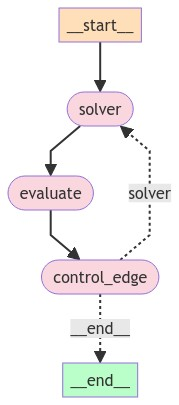

In [15]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

Now that we've created our graph, let's see the type of question it will have to solve.

In [18]:
input_state = input_states[0].copy()
# We will reduce the test cases to speed this notebook up
input_state["test_cases"] = input_state["test_cases"][:3]
print(input_state["messages"][0][1])


Farmer John has $N$ ($1 \leq N \leq 2 \cdot 10^5$) farms, numbered from $1$ to
$N$. It is known that FJ closes farm $i$ at time $c_i$. Bessie wakes up at time
$S$, and wants to maximize the productivity of her day by visiting as many farms
as possible before they close. She plans to visit farm $i$ on time $t_i + S$.
Bessie must arrive at a farm strictly before Farmer John closes it to actually visit it.

Bessie has $Q$ $(1 \leq Q \leq 2 \cdot 10^5)$ queries. For each query, she gives
you two integers $S$ and $V$. For each query, output whether Bessie can visit at
least $V$ farms if she wakes up at time $S$.

INPUT FORMAT (input arrives from the terminal / stdin):
The first line consists of $N$ and $Q$.

The second line consists of $c_1, c_2, c_3 \dots c_N$ ($1 \leq c_i \leq 10^6$).

The third line consists of $t_1, t_2, t_3 \dots t_N$ ($1 \leq t_i \leq 10^6$).

The next $Q$ lines each consist of two integers $V$ ($1 \leq V \leq N$) and $S$
($1 \leq S \leq 10^6$).

OUTPUT FORMAT (print

Pretty difficult! Let's run our simple "zero-shot" agent below to see how it fares. **It most likely will not be able to solve this question** (unless you are using a more powerful model than what I had available at the time of writing this tutorial (2024/04/20).
We will trace the trajectory to LangSmith to review the series of submissions. To reduce the packet size, we will use "`hide_inputs`" and filter out the test_cases. All this is optional but useful for development. 

**Note:** We _expect_ a **GraphRecursionError** here from it not being able to answer it correctly in the allocated number of steps.

In [19]:
from langchain_core.messages import BaseMessage
from langchain_core.tracers.context import tracing_v2_enabled
from langsmith import Client


# We don't need to include all the test cases in our traces.
def _hide_test_cases(inputs):
    copied = inputs.copy()
    # These are tens of MB in size. No need to send them up
    copied["test_cases"] = f"..."
    return copied


client = Client(hide_inputs=_hide_test_cases, hide_outputs=_hide_test_cases)
with tracing_v2_enabled(client=client):
    events = graph.stream(input_state)
    for event in events:
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print(
                    "Assistant:",
                    str(value["messages"][-1].content).replace("\n", "\\n")[:50],
                )

Assistant: [{'text': "<thinking>\nThe key pieces of informati
Assistant: Incorrect submission. Please respond with updated 
Assistant: [{'id': 'toolu_013zRr1Kwb86hHFwkZ9CvpZn', 'input':
Assistant: Incorrect submission. Please respond with updated 
Assistant: [{'id': 'toolu_015bqA7g5BdgiNMD2zjSzkPm', 'input':
Assistant: Incorrect submission. Please respond with updated 
Assistant: [{'id': 'toolu_0197dULeXoTkPaaVkEjjKe61', 'input':
Assistant: Incorrect submission. Please respond with updated 
Assistant: <result>\nI apologize, but after carefully reviewi
Assistant: No code submitted. Please try again using the corr
Assistant: [{'text': "<thinking>\nYou're absolutely right, I 
Assistant: Incorrect submission. Please respond with updated 
Assistant: [{'id': 'toolu_01ScGxFZAmzuDE6tozSc85br', 'input':
Assistant: Incorrect submission. Please respond with updated 
Assistant: [{'id': 'toolu_01G61PAeSK6FiiCZVthhPXZ7', 'input':
Assistant: Incorrect submission. Please respond with updated 
Assistan

GraphRecursionError: Recursion limit of 25 reachedwithout hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.

Failed to batch ingest runs: LangSmithError("Failed to POST https://api.smith.langchain.com/runs/batch in LangSmith API. HTTPSConnectionPool(host='api.smith.langchain.com', port=443): Read timed out. (read timeout=10.0)\n")


It wasn't able to solve it in time **but that's OK**! If it were easy, this paper would be a lot shorter :)

You can vew the [agent's full LangSmith trace](https://smith.langchain.com/public/61c84ad0-51db-40f1-b50d-6983d9481ca1/r) at the provided link.

In the next section we will add an improvement: "episodic memory".

## Part 2: Few-shot Retrieval

Even with reflective tool calling, our baseline agent from part 1 struggled with this difficult task. One way to "teach" an LLM how to better perform a task is through demonstrations, also known as "few-shot examples."

What the authors of the USACO paper call "episodic memory" **is really just few-shot prompting over similar examples.**

Each examples in this case is a different problems + solution within the dataset. The term "episodic memory" makes sense if you pretend your agent has already "solved" these problems and is recalling its solutions to them.

This section adds the "Episodic Memory" components from "Part 2" in the diagram below.

![Part 2 diagram](./img/diagram-part-2.png)

Note that this memory step is performed **one time**,  **before** the logic of our zero-shot loop from part 1. The steps are as follows:

1. Prompt the LLM to generate a candidate solution.
2. Use the text of the candidate solution to retrieve the N most similar (problem, solution) pairs.
3. Format this result in the Zero-shot agent's prompt.

Below, let's implement our episodic memory as a retriever. We will follow the paper's retriever selection and use [BM25](https://en.wikipedia.org/wiki/Okapi_BM25).

In [ ]:
%pip install --upgrade --quiet  rank_bm25

#### State

The state is mostly recycled from part 1. Add additional "candidate" and "examples" fields to store the information for the memory steps.

In [306]:
from typing import Annotated, Optional

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class TestCase(TypedDict):
    inputs: str
    outputs: str


class State(TypedDict):
    # NEW! Candidate for retrieval + formatted fetched examples as "memory"
    candidate: AIMessage
    examples: str
    # Repeated from Part 1
    messages: Annotated[list[AnyMessage], add_messages]
    test_cases: list[TestCase]
    runtime_limit: int
    status: str

#### Nodes 1 and 3: Draft & Solver

Let's create our "agent". We will modify the `Solver` from Part 1 to reuse it for  for the agent node and for the candidate program generation node ("draft").

In [307]:
from langchain import hub
from langchain_anthropic import ChatAnthropic


class Solver:
    def __init__(self, llm: BaseChatModel, prompt: ChatPromptTemplate):
        self.runnable = prompt | llm.bind_tools([writePython])

    def __call__(self, state: State) -> dict:
        # Our agent only can see the "messages" and will ignore the test info
        inputs = {"messages": state["messages"]}
        has_examples = bool(state.get("examples"))
        output_key = "candidate"  # Used in the draft node
        if has_examples:
            output_key = "messages"
            # Used in the solve node
            inputs["examples"] = state["examples"]
        response = self.runnable.invoke(inputs)
        if not response.content:
            return {
                output_key: AIMessage(
                    content="I'll need to think about this step by step."
                )
            }
        return {output_key: response}


prompt = hub.pull("wfh/usaco-draft-solver")
llm = ChatAnthropic(model="claude-3-opus-20240229")

draft_solver = Solver(llm, prompt.partial(examples=""))
solver = Solver(llm, prompt)

#### Node 2: Retrieve

The retrieve node takes a candidate solution (made by the 'solver' node), uses _this_ to search for similar examples, then formats those in the message.

In [308]:
# We will test our agent on index 0 (the same as above).
# Later, we will test on index 2 (the first 'silver difficulty' question)
test_indices = [0, 2]
train_ds = [row for i, row in enumerate(ds) if i not in test_indices]
test_ds = [row for i, row in enumerate(ds) if i in test_indices]

In [309]:
from langchain_community.retrievers import BM25Retriever


def format_example(row):
    question = row["description"]
    answer = row["solution"]
    return f"""<problem>
{question}
</problem>
<solution>
{answer}
</solution>"""


# Skip our 'test examples' to avoid cheating
# This is "simulating" having seen other in-context examples
retriever = BM25Retriever.from_texts([format_example(row) for row in train_ds])

Now define the node. Any node can optionally accept a second `config` positional argument. This contains `configurable` params you can adjust when invoking the graph. For instance, we can
adjust the top `k` examples to retrieve for our agent.

In [310]:
from langchain_core.runnables import RunnableConfig


def retrieve_examples(state: State, config: RunnableConfig):
    top_k = config["configurable"].get("k") or 2
    ai_message: AIMessage = state["candidate"]
    if not ai_message.tool_calls:
        # We err here. To make more robust, you could loop back
        raise ValueError("Draft agent did not produce a valid code block")
    code = ai_message.tool_calls[0]["args"]["code"]
    examples_str = "\n".join(
        [doc.page_content for doc in retriever.invoke(code)[:top_k]]
    )
    examples_str = f"""
You previously solved the following problems in this competition:
<Examples>
{examples_str}
<Examples>
Approach this new question with similar sophistication."""
    return {"examples": examples_str}

#### Graph

Now let's put it all together. The graph is slightly more complicated than in part 1, since we have to add the initial "draft" and "retrieve" nodes to our agent loop.

In [311]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, StateGraph

builder = StateGraph(State)
builder.add_node("draft", draft_solver)
builder.set_entry_point("draft")
builder.add_node("retrieve", retrieve_examples)
builder.add_node("solve", solver)
builder.add_node("evaluate", evaluate)
# Add connectivity
builder.add_edge("draft", "retrieve")
builder.add_edge("retrieve", "solve")
builder.add_edge("solve", "evaluate")


def control_edge(state: State):
    if state.get("status") == "success":
        return END
    return "solve"


builder.add_conditional_edges("evaluate", control_edge, {END: END, "solve": "solve"})


checkpointer = SqliteSaver.from_conn_string(":memory:")
graph = builder.compile(checkpointer=checkpointer)

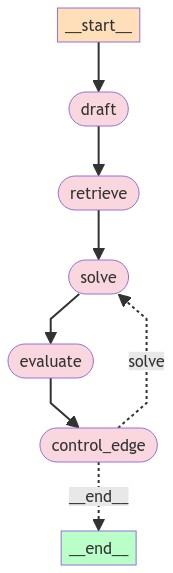

In [27]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

Let's try again on this problem:

In [28]:
config = {"configurable": {"thread_id": "question-1", "k": 2}}
with tracing_v2_enabled(client=client):
    events = graph.stream(input_state, config)
    for event in events:
        for value in event.values():
            messages = value.get("messages")
            if messages:
                print(
                    "Assistant:",
                    str(value["messages"][-1].content).replace("\n", "\\n")[:50],
                )
            elif value.get("examples"):
                print("Retrieved examples:\n\n", value["examples"][:100] + "...")
            elif value.get("candidate"):
                print(str(value["candidate"].content)[:200])

[{'text': "<thinking>\nThe key aspects of this problem are:\n1. We have N farms, each with a closing time c_i and a travel time t_i from Bessie's starting point. \n2. Bessie wakes up at time S for eac
Retrieved examples:

 
You previously solved the following problems in this competition:
<Examples>
<problem>
Bessie is bo...
Assistant: [{'text': "<thinking>\nThe relevant tool here is w


**No recursion error!** You can view the [full LangSmith trace](https://smith.langchain.com/public/1f1c4db3-b53c-49bf-a287-a2b51c081156/r/31f90ddd-8ae9-4b23-a2b5-b0c0d67c5cc3) of the graph's execution at the provided link to confirm the results. You can also check the graph state to confirm that it passed all test cases successfully:

In [29]:
checkpoint = graph.get_state(config)
checkpoint.values["status"]

'success'

**Congrats!** You added "episodic memory" to your agent to fetch few-shot examples and solve this bronze level programming olympiad question!

Our agent is still limited, however. Let's test it out on a more challenging 🪙🏆silver✨ level question:

In [32]:
silver_row = test_ds[1]
silver_row["problem_level"]

'silver'

In [312]:
silver_input = {
    "messages": [("user", silver_row["description"])],
    "test_cases": silver_row["test_cases"],
    "runtime_limit": silver_row["runtime_limit"],
    "status": "in_progress",
}


config = {"configurable": {"thread_id": "silver-question-1", "k": 2}}
with tracing_v2_enabled(client=client):
    events = graph.stream(silver_input, config)
    for event in events:
        for value in event.values():
            messages = value.get("messages")
            if messages:
                if isinstance(messages, list):
                    messages = value["messages"][-1]
                print(
                    "Assistant:",
                    str(messages.content).replace("\n", "\\n")[:50],
                )
            elif value.get("examples"):
                print("Retrieved examples:\n\n", value["examples"][:100] + "...")
            elif value.get("candidate"):
                print(str(value["candidate"].content)[:200])

[{'text': "<thinking>\nTo solve this problem, we need to:\n1. Read in the port connections and directions\n2. Simulate Bessie's journey by following the directions K times\n3. Output the final port Be
Retrieved examples:

 
You previously solved the following problems in this competition:
<Examples>
<problem>

Farmer John...
Assistant: [{'text': '<thinking>\nTo solve this problem, we n
Assistant: Incorrect submission. Please respond with updated 
Assistant: [{'text': "<thinking>\nThe previous code submissio
Assistant: Incorrect submission. Please respond with updated 
Assistant: [{'text': "<thinking>\nThe previous code passed on
Assistant: Incorrect submission. Please respond with updated 
Assistant: [{'text': "<thinking>\nApologies for the incomplet
Assistant: Incorrect submission. Please respond with updated 
Assistant: [{'text': "<thinking>\nI apologize for the confusi
Assistant: KeyError('code')\nMake all fixes using the writePy
Assistant: [{'id': 'toolu_011YPfiRvvaKv9neSAK9u5B7', 

GraphRecursionError: Recursion limit of 25 reachedwithout hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.

**Still too hard!** AGI not achieved yet. To investigate our agent's trajectory in detail, check out the [full LangSmith trace](https://smith.langchain.com/public/13018b44-0c4f-4f1a-9e6d-dea1f3fd4705/r).

Our agent isn't good enough to be autonomous. The great thing about LangGraph is you don't have to decide between "autonomous agent" and "simple DAG": you can inject control and user-interfaces wherever it can usefully benefit your application.

## Part 3: Human-in-the-loop

Our retrieval-enhanced agent was able to solve the `bronze`-level question but still failed for those with the more challenging **silver** difficulty. 

Recall that the paper presented 3 complementary techniques that improved performance:

1. Reflection: explicitly prompting the LLM to "reflect" on its mistakes can help it
2. Few-shot prompting: retrieving relevant, high-quality examples as "memory"
3. **Human-in-the-loop collaboration:**  without giving the correct answer, the human is allowed to help the agent reflect on its appraoch and point it in a better direction.


In this section, we will add the "human" node (marked as "part 3" in the diagram below), completing our agent graph:

![Diagram](./img/diagram.png)

From an ML perspective, this is a bit of a [clever hans](https://en.wikipedia.org/wiki/Clever_Hans), but from the application designer's perspective, where the primary goal is to achieve a higher combined success rate, letting the human interject with thoughts and insights is only natural. 

In either case, adding a human check to a LangGraph instance requires only 1 or 2 extra lines of code. Let's do so by making two changes:

1. Add a new "`human`" node after the "`evaluate`" node to optionally comment on the test results before passing it back to the agent.
2. Instruct the graph to `interrupt_before` the "`human`" node to give the user a chance to modify the trajectory.


Start assembling your graph below. The following section is identical to our application in part 2:

In [285]:
# This is all the same as before
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, StateGraph

builder = StateGraph(State)
prompt = hub.pull("wfh/usaco-draft-solver")
llm = ChatAnthropic(model="claude-3-opus-20240229", max_tokens_to_sample=4000)

draft_solver = Solver(llm, prompt.partial(examples=""))
builder.add_node("draft", draft_solver)
builder.set_entry_point("draft")
builder.add_node("retrieve", retrieve_examples)
solver = Solver(llm, prompt)
builder.add_node("solve", solver)
builder.add_node("evaluate", evaluate)
builder.add_edge("draft", "retrieve")
builder.add_edge("retrieve", "solve")
builder.add_edge("solve", "evaluate")

Now, add the "`human`" node. This is a placeholder node whose **sole purpose is to wait** before passing back to the agent. This gives us the option of weighing in and steering the agent's attempts.

In [286]:
builder.add_node("human", lambda state: {})
# Always give back to the agent
builder.add_edge("human", "solve")

Now finish by updating the control edge, this time routing to "human" (instead of "solve") if the tests fail. Compile the graph with `interrupt_before=["human"]` to instruct the agent to wait for human input before continuing execution.

In [287]:
def control_edge(state: State):
    if state.get("status") == "success":
        return END
    # Modified: used to be "solve" in Part 2.
    return "human"


builder.add_conditional_edges("evaluate", control_edge, {END: END, "human": "human"})


checkpointer = SqliteSaver.from_conn_string(":memory:")
graph = builder.compile(
    checkpointer=checkpointer,
    # New: this tells the graph to break any time it goes to the "human" node
    interrupt_before=["human"],
)

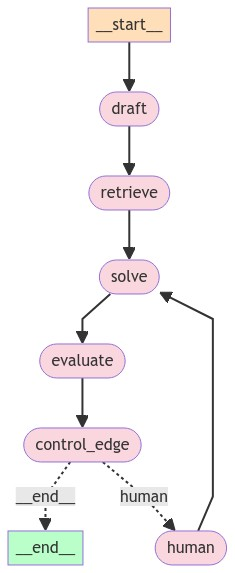

In [288]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

As you can see in the graph above, the structure is the same as Part 2, except that we've inserted a "`human`" breakpoint between the "`evaluate`" and "`solve`" nodes.

Let's try this question again!

In [289]:
config = {"configurable": {"thread_id": "silver-hl-1", "k": 2}}
with tracing_v2_enabled(client=client):
    events = graph.stream(silver_input, config)
    for event in events:
        for value in event.values():
            messages = value.get("messages")
            if messages:
                if isinstance(messages, list):
                    messages = value["messages"][-1]
                print(
                    "Assistant:",
                    str(messages.content).replace("\n", "\\n")[:50],
                )
            elif value.get("examples"):
                print("Retrieved examples:\n\n", value["examples"][:100] + "...")
            elif value.get("candidate"):
                print(str(value["candidate"].content)[:200])

[{'text': "<thinking>\nThe relevant tool here is writePython, since the user has requested a Python solution to this programming problem.\n\nLooking at the required parameters for writePython:\n\nreas
Retrieved examples:

 
You previously solved the following problems in this competition:
<Examples>
<problem>

Farmer John...
Assistant: [{'text': '<thinking>\nThis problem is asking us t
Assistant: Incorrect submission. Please respond with updated 


**⏰Time to weigh in⏰:** our model failed in its first attempt, so we have the opportunity to give it some advice.

Recall the original question:

In [290]:
snapshot = graph.get_state(config)
print(snapshot.values["messages"][0].content)

Problem 3: Luxury River Cruise [Josh Alman and Nathan Pinsker, 2013]

Farmer John is taking Bessie and the cows on a cruise! They are sailing on a 
network of rivers with N ports (1 <= N <= 1,000) labeled 1..N, and Bessie 
starts at port 1. Each port has exactly two rivers leading out of it which 
lead directly to other ports, and rivers can only be sailed one way.

At each port, the tour guides choose either the "left" river or the "right" 
river to sail down next, but they keep repeating the same choices over and 
over. More specifically, the tour guides have chosen a short sequence of M 
directions (1 <= M <= 500), each either "left" or "right", and have
repeated it K times (1 <= K <= 1,000,000,000). Bessie thinks she is going
in circles -- help her figure out where she ends up!

PROBLEM NAME: cruise

INPUT FORMAT:

* Line 1: Three space-separated integers N, M, and K.

* Lines 2..N+1: Line i+1 has two space-separated integers,
        representing the number of the ports that port 

And then review the agent's current submission:

In [291]:
snapshot = graph.get_state(config)
print(snapshot.values["messages"][-2].content[0]["text"])
print("\n\nCode:\n\n")
print(snapshot.values["messages"][-2].tool_calls[0]["args"]["code"])

<thinking>
This problem is asking us to simulate Bessie's journey along the river network, following the repeated sequence of left/right directions. The key aspects are:

1. We have a river network represented as a graph, with each port having a "left" and "right" outgoing edge to other ports. 
2. There is a sequence of M directions (L or R) that is repeated K times.
3. We need to determine Bessie's final port after following this repeated sequence starting from port 1.

To solve this, the main steps would be:
1. Read in the river network graph 
2. Read in the sequence of directions
3. Simulate Bessie's journey by repeatedly following the direction sequence K times, updating her current port each step
4. Output the final port Bessie ends up at

The provided tools would allow us to implement this solution in Python. We have the port count N, sequence length M, repetition count K, the graph edges, and direction sequence all provided as inputs. So we have the necessary parameters to invok

In [292]:
print(snapshot.values["messages"][-1].content[:200])

Incorrect submission. Please respond with updated code.
Pass rate: 0/10
Results:
<test id=0>
failed: Traceback (most recent call last):
  File "<string>", line 6, in <module>
NameError: name 'i' is no


The agent failed. It's on the right track but clearly doesn't handle all the edge cases.

The agent needs to remember that simulation should include the cycle + whatever steps led up to the example. It could use the "tortoise and hare" algo for cycle detection, use the simulated path and break if and when a repeat is detected, and then 

Let's let the agent know this by **updating the graph state**.

In [293]:
updated_config = graph.update_state(
    config,
    values={
        "messages": [
            (
                "user",
                f"""Consider breaking down the algorithm into separate parts: reading inputs, detecting cycles using the tortoise and hare algorithm, and determining Bessie's final position by skipping ahead K steps.

Read the inputs into three arrays:
- Two arrays L and R for the ports (adjust for 0-based indexing)
- A third array S for the direction sequence

Optimize by multiplying K by M before the main loop to convert the number of repetitions into the total number of steps.

Use the tortoise and hare algorithm to detect the cycle:
- Define a helper function get_next(v) that returns the next position and direction index
- Initialize two pointers s0 and s1 to (0, 0)
- In each iteration:
  - Move s0 by 1 step and s1 by 2 steps using get_next()
  - If s0 equals s1, decrement K by 1 and break out of the loop
  - Otherwise, decrement K by 1
- After the loop, if K is not 0, there is a cycle

To find the cycle length:
- Initialize a counter variable rho to 1
- Move s0 by 1 step using get_next()
- Enter a loop:
  - Move s0 by 1 step using get_next()
  - Increment rho
  - If s0 equals s1, break out of the loop

Skip ahead by reducing K modulo rho.

Simulate the remaining steps:
- While K > 0, move s0 to the next position using get_next() and decrement K

Print the final position (converted to 1-based indexing).

Pay close attention to the initialization and movement of pointers during cycle detection and length calculation. Ensure that the logic is correct and handles all cases accurately.""",
            )
        ]
    },
)

Now the graph's state contains our new message.

In [294]:
graph.get_state(config).values["messages"][-1]

HumanMessage(content="Consider breaking down the algorithm into separate parts: reading inputs, detecting cycles using the tortoise and hare algorithm, and determining Bessie's final position by skipping ahead K steps.\n\nRead the inputs into three arrays:\n- Two arrays L and R for the ports (adjust for 0-based indexing)\n- A third array S for the direction sequence\n\nOptimize by multiplying K by M before the main loop to convert the number of repetitions into the total number of steps.\n\nUse the tortoise and hare algorithm to detect the cycle:\n- Define a helper function get_next(v) that returns the next position and direction index\n- Initialize two pointers s0 and s1 to (0, 0)\n- In each iteration:\n  - Move s0 by 1 step and s1 by 2 steps using get_next()\n  - If s0 equals s1, decrement K by 1 and break out of the loop\n  - Otherwise, decrement K by 1\n- After the loop, if K is not 0, there is a cycle\n\nTo find the cycle length:\n- Initialize a counter variable rho to 1\n- Move s

Let's let the agent try again. Call `stream` with `None` to just use the inputs loaded from the memory. We will skip our human review for the next few attempats
to see if it can correct itself.

In [295]:
num_trials = 1
with tracing_v2_enabled(client=client):
    for _ in range(num_trials):
        events = graph.stream(None, updated_config)
        for event in events:
            for value in event.values():
                messages = value.get("messages")
                if messages:
                    if isinstance(messages, list):
                        messages = value["messages"][-1]
                    print(
                        "Assistant:",
                        str(messages.content).replace("\n", "\\n")[:50],
                    )
                elif value.get("examples"):
                    print("Retrieved examples:\n\n", value["examples"][:100] + "...")
                elif value.get("candidate"):
                    print(str(value["candidate"].content)[:200])
        if graph.get_state(config).values["status"] == "success":
            break
        print("Continuing...")

Assistant: [{'text': "<thinking>\nThank you for the detailed 
Assistant: Incorrect submission. Please respond with updated 
Continuing...


In [301]:
most_recent_state = list(graph.get_state_history(config))[0]

OK so the agent tried again. Check out the [LangSmith trace](https://smith.langchain.com/public/707be522-9eaf-4b6a-994e-1742f421a433/r/add3d8e7-85b1-40cf-bbd3-e78c50f835e8) from this step to see its update.

In [303]:
snapshot = graph.get_state(most_recent_state.config)
ai_message = snapshot.values["messages"][-2]
if ai_message.content:
    print(ai_message.content)
print("\n\nCode:\n\n")
print(ai_message.tool_calls[0]["args"]["code"] if ai_message.tool_calls else "N/A")

In [298]:
print(snapshot.values["messages"][-1].content[:200])

Incorrect submission. Please respond with updated code.
Pass rate: 8/10
Results:
<test id=0>
wrong answer. Expected '4
', got '3
'
</test>
<test id=1>
passed
</test>
<test id=2>
passed
</test>
<test i


Still getting most test cases wrong.

Let's provide more feedback.

In [299]:
updated_config = graph.update_state(
    updated_config,
    values={
        "messages": [
            (
                "user",
                """That's better, but you're still getting some errors. Let's double check some things:
                       
1. When calculating the cycle length, make sure the initialization and movement of the pointers is correct. Double-check the logic there and see if you can spot any discrepancies.
2. Check the condition for whether there's a cycle after the main loop to ensure it covers all cases, like if  K becomes 0 in the last iteration.

Think step by step through youur implementation and update using the writePython tool.""",
            )
        ]
    },
)

Now that we've provided this feedback, let's give the agent a few attempts at solving it before we weigh in again.

In [300]:
num_trials = 2
with tracing_v2_enabled(client=client):
    for _ in range(num_trials):
        events = graph.stream(None, updated_config)
        for event in events:
            for value in event.values():
                messages = value.get("messages")
                if messages:
                    if isinstance(messages, list):
                        messages = value["messages"][-1]
                    print(
                        "Assistant:",
                        str(messages.content).replace("\n", "\\n")[:50],
                    )
                elif value.get("examples"):
                    print("Retrieved examples:\n\n", value["examples"][:100] + "...")
                elif value.get("candidate"):
                    print(str(value["candidate"].content)[:200])
        if graph.get_state(config).values["status"] == "success":
            break
        print("Continuing...")

Assistant: [{'text': "<thinking>\nAfter re-analyzing the algo
Assistant: Incorrect submission. Please respond with updated 
Continuing...
Assistant: [{'text': "<thinking>\nThank you for the breakdown


You can review [a LangSmith trace (link)](https://smith.langchain.com/public/d383e743-f8f1-4206-9dce-47627f152612/r/3f89582f-9107-461a-a34e-608d52641eeb) of the agent's response to your feedback at the provided link.

In [305]:
snapshot = graph.get_state(config)
print(snapshot.values["status"])

success


**Success!** - the LLM really wouldn't have been able to come to the correct answer without detailed human involvement.

## Conclusion

Congrats on making it to the end! In this tutorial, you implemented an agent in LangGraph capable of solving challenging programming problems. You did so by leveraging a few common techniques to improve performance, including:

1. **Reflection**: while we didn't implement an explicit reflection step, our prompt and tool invocation was designed to encourage critique of previous outputs. You added this in Part 1.
2. **Retrieval**: the "episodic memory" of the agent retrieves high-quality few-shot examples from our corpora of programming problems to help solve the **bronze** level question. In Part 2, you implemented a retrieval memory as an initial step.
3. **Human-in-the-loop**: LLM-powered agents are still too weak to answer all these questions autonomously, but at times, they can get most of the way there and land on the right answer with human feedback. In Part 3, you used `interrupt_before` on an additional placeholder "human" node and then included your feedback by using `update_state` on the graph.


LLMs are not capable of solving all these problems autonomously, but through better prompting and clever engineering, you can create a system that is able to more reliably arrive at the proper solution.